In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
connection_test = dict(database='test',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student-rw',
                  password='656e2b0c9c')

In [6]:
# step 2
# Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.
q1 = '''
    SELECT COUNT(*)
    FROM ldn_listings'''
str_count = ph.read_clickhouse(query = q1, connection = connection_default)
str_count

,count()
0,85207


In [8]:
# step 3
# Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:
# price – цена за ночь
# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

q2 = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price  
    FROM 
        ldn_listings
    ORDER BY id
    LIMIT 1000
    '''
ldn_listings_1000 = ph.read_clickhouse(query = q2, connection = connection_default)
ldn_listings_1000.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [10]:
# step 3
# Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.
# В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.
price_quant_75 = ldn_listings_1000 \
    .groupby('room_type', as_index = False) \
    .quantile(q = 0.75)
price_quant_75

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [35]:
# step 4
# К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
# В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32
q3 =  '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS review_scores_rating
    FROM 
        ldn_listings
    WHERE  review_scores_rating IS NOT NULL
    ORDER BY id
    LIMIT 1000
    '''
ldn_listings_1000_score = ph.read_clickhouse(query = q3, connection = connection_default)
ldn_listings_1000_score.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [36]:
# step 4
# 1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)
aver_price_and_score = ldn_listings_1000_score \
    .groupby('room_type', as_index = False) \
    .agg({'price' : 'mean', 'review_scores_rating' : 'mean'})
aver_price_and_score

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


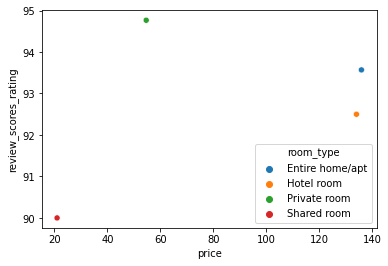

In [39]:
# step 4
# 2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

sns.scatterplot(data=aver_price_and_score, x=aver_price_and_score.price, y=aver_price_and_score.review_scores_rating, hue=aver_price_and_score.room_type)

In [58]:
# step 5
# Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). 
# Для каждого уникального пользователя выгрузите только две колонки:
# host_id – идентификатор хозяина (уникальный)
# host_verifications – какими способами хост подтвердил свой профиль

q4 =  '''
    SELECT 
        DISTINCT host_id,
        host_verifications
    FROM 
        ldn_listings
    WHERE  experiences_offered != 'none'
            '''
ldn_listings_experiences = ph.read_clickhouse(query = q4, connection = connection_default)
ldn_listings_experiences.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [59]:
# step 5
# Затем обработайте столбец host_verifications:
# В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). 
# Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта 

ldn_listings_experiences.host_verifications = \
    ldn_listings_experiences.host_verifications \
    .str.replace("[[']", '', regex = True) \
    .replace("[]]", '', regex = True) \
    .str.split(',')
ldn_listings_experiences.head()

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_i..."
3,167107,"[email, phone, manual_offline, jumio, offl..."
4,103583,"[email, phone, reviews, offline_government_..."


In [60]:
# step 5
# Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации
count_host_verification = ldn_listings_experiences \
    .explode('host_verifications') \
    .value_counts(subset = 'host_verifications')
count_host_verification

host_verifications
email                     1345
 phone                    1345
 reviews                  1309
 government_id            1196
 jumio                    1115
 offline_government_id     469
 work_email                279
 facebook                  270
 selfie                    252
 identity_manual           227
 manual_offline             70
 google                     34
 kba                        27
phone                       16
 manual_online              16
 sent_id                     6
dtype: int64

In [62]:
# step 6
# Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 
# Сгруппируйте данные по району 
# и виду впечатления 
# и посчитайте количество объявлений. 
# Новый столбец назовите experiences_count
# Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. 
q5 =  '''
    SELECT 
       neighbourhood_cleansed,
       experiences_offered,
       COUNT(id) AS experiences_count
    FROM 
        ldn_listings
    WHERE  
        experiences_offered != 'none'
    GROUP BY 
        neighbourhood_cleansed,
        experiences_offered    
    ORDER BY experiences_count DESC
    LIMIT 100
            '''
ldn_listings_experiences_count = ph.read_clickhouse(query = q5, connection = connection_default)
ldn_listings_experiences_count

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [63]:
# step 6
# Затем преобразуйте данные с помощью pivot, 
# поместив в индексы название района, 
# столбцы – вид впечатления, 
# а значения – число объявлений с таким впечатлением для каждого района. 
for_heatmap = ldn_listings_experiences_count \
    .pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count')
for_heatmap

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


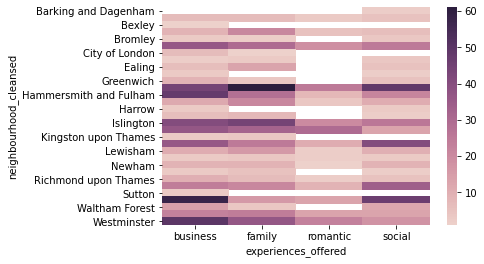

In [64]:
# step 6
# Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True)

sns.heatmap(for_heatmap, cmap=sns.cubehelix_palette(as_cmap=True))

In [4]:
# step 7
# Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 
# Необходимые для составления запроса столбцы:

# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# price – цена за ночь 
# experiences_offered – вид доступного впечатления (оставить не 'none')
q6 =  '''
    SELECT 
       room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM 
        ldn_listings
    WHERE  
        experiences_offered != 'none'
                '''
ldn_listings_exp_type_price = ph.read_clickhouse(query = q6, connection = connection_default)
ldn_listings_exp_type_price

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


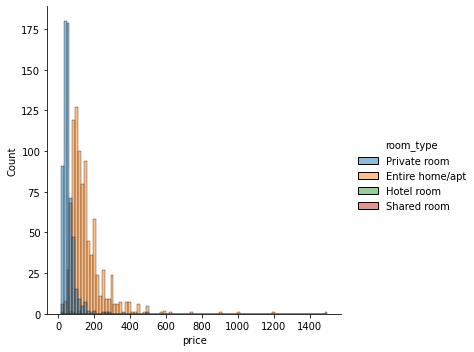

In [8]:
# step 7
# Далее постройте два графика, используя distplot из библиотеки seaborn:
# На первом отобразите исходные распределения цен для каждого типа жилья

sns.displot(data=ldn_listings_exp_type_price, x = 'price', hue='room_type', kind="hist")

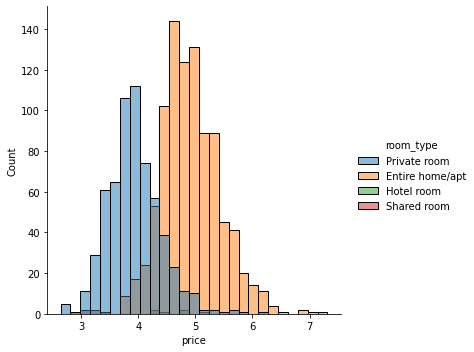

In [10]:
sns.displot(data=ldn_listings_exp_type_price, x = np.log(ldn_listings_exp_type_price.price), hue='room_type', kind="hist")

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


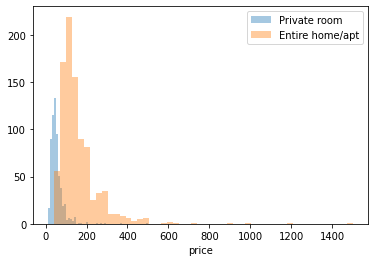

In [11]:
sns.distplot(ldn_listings_exp_type_price.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(ldn_listings_exp_type_price.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
plt.legend()
plt.show()

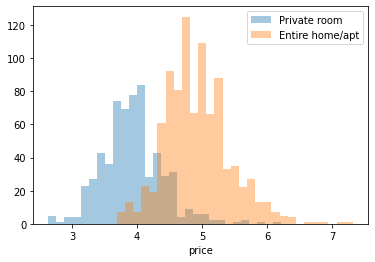

In [12]:
sns.distplot(np.log(ldn_listings_exp_type_price.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(ldn_listings_exp_type_price.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
plt.legend()
plt.show()

In [5]:
# step 8
# Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# price – цена за ночь
# first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
# Ограничение поставьте на 1000 строк.

q7 =  '''
    SELECT 
       room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        first_review
    FROM 
        ldn_listings
    WHERE  
        first_review > '2010-01-01'
    LIMIT 1000
                '''
ldn_listings_st8 = ph.read_clickhouse(query = q7, connection = connection_default)
ldn_listings_st8

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [14]:
# step8
# преобразуем first_review к соответствующему типу
ldn_listings_st8.first_review = pd.to_datetime(ldn_listings_st8.first_review)

In [15]:
# step8
# извлекаем из даты год

ldn_listings_st8['year'] = ldn_listings_st8.first_review.dt.year

,room_type,price,first_review,year
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010
...,...,...,...,...
995,Private room,45.0,2012-11-07,2012
996,Private room,51.0,2013-03-18,2013
997,Entire home/apt,79.0,2012-09-17,2012
998,Entire home/apt,110.0,2012-09-24,2012


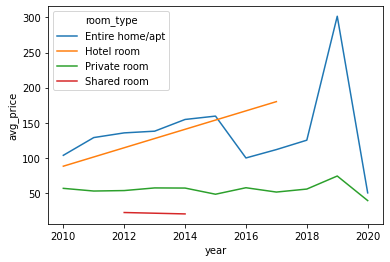

In [19]:
# step 8
# Используя библиотеку seaborn и функцию lineplot, 
# постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). 
# Датафрейм должен быть отсортирован по годам.
for_lineplot = ldn_listings_st8 \
    .groupby(['year', 'room_type'], as_index = False) \
    .agg({'price' : 'mean'}) \
    .rename(columns = {'price' : 'avg_price'})
sns.lineplot(data = for_lineplot, x = 'year', y =  'avg_price', hue = 'room_type')